# Parameter Estimation I

Relatively advanced problems in optimization and nonlinear regression part 2...

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import csv
from math import ceil, floor
import pandas as pd

## Nonlinear Least Squares Recap:

No matter what problem you are trying to solve, the method behind nonlinear least squares is always the same:

1. Propose a model that includes your variable parameters (e.g., a rate constant or reaction order)
2. Use that model to calculate the value of your measurable quantity at each experimental condition (e.g., a concentration at a specific time)
3. Calculate the square error between your measurement and the value predicted by your model
4. Sum the square errors for each data point.
5. Use an iterative solver to vary the parameters of interest until the sum of square errors is at a minimum.

## Example Problem 01

The following data analysis is representative of the type of work we do in our research group.  We will start with a reaction:

$$A + B\longrightarrow C$$

For which we have collected a lot of kinetic data.  Specifically, we have estimated rates of reaction by measuring the effluent flowrate of species C in a differential plug flow reactor having a volume of 1.0L.  For this case study, we measured rates of reaction at various concentrations of A, concentrations of B, and reaction temperature. Eventually, we'll consider the full data set, but for right now, let's just look at data collected at 573K.  This is saved in the DATA1 file included with this worksheet.

Load the rate data obtained at 573K. In this data set, concentrations of A (Column 1) and B (Column 2) are in moles per liter, temperature (Column 3) is in Kelvin, and the rate of reaction (Column 4) is in moles per liter per minute.

1. Determine the reaction orders in A and B
2. Propose a rate law that is consistent with this behavior.


In [13]:
#Load Experimental Times; convert to 1D numpy array
file = open("DATA1.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
DATA1 = np.array(rows, dtype = 'float')

labels = ['CAf (mol/L)', 'CBf (mol/L)', 'T (K)', 'r (mol/L/min)']
df = pd.DataFrame(DATA1, columns = labels)
#display(df)

EXP1  = DATA1[0:17, :]
EXP2  = DATA1[17:,:]

CA1  = EXP1[:,0]
CB1  = EXP1[:,1]
T1   = EXP1[:,2]
r1   = EXP1[:,3]

CA2  = EXP2[:,0]
CB2  = EXP2[:,1]
T2   = EXP2[:,2]
r2   = EXP2[:,3]

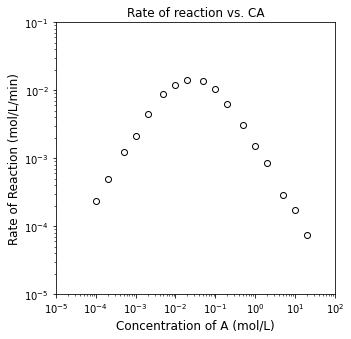

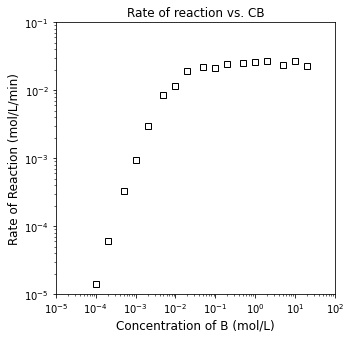

In [14]:
plt.figure(1, figsize = (5, 5))
plt.loglog(CA1, r1, marker = 'o', markerfacecolor = 'none', markeredgecolor = 'black', linestyle = 'none')
plt.title('Rate of reaction vs. CA')
plt.xlim(1e-5, 1e2)
plt.ylim(1e-5, 1e-1)
plt.xlabel('Concentration of A (mol/L)', fontsize = 12)
plt.ylabel('Rate of Reaction (mol/L/min)', fontsize = 12)
plt.show()

plt.figure(2, figsize = (5, 5))
plt.loglog(CB2, r2, marker = 's', markerfacecolor = 'none', markeredgecolor = 'black', linestyle = 'none')
plt.title('Rate of reaction vs. CB')
plt.xlim(1e-5, 1e2)
plt.ylim(1e-5, 1e-1)
plt.xlabel('Concentration of B (mol/L)', fontsize = 12)
plt.ylabel('Rate of Reaction (mol/L/min)', fontsize = 12)
plt.show()

In [16]:
coeffs1low  = np.polyfit(np.log(CA1[0:3]), np.log(r1[0:3]), 1)
coeffs2low  = np.polyfit(np.log(CB2[0:3]), np.log(r2[0:3]), 1)
coeffs1high = np.polyfit(np.log(CA1[-4:]), np.log(r1[-4:]), 1)
coeffs2high = np.polyfit(np.log(CB2[-4:]), np.log(r2[-4:]), 1)

α_low  = coeffs1low[0]
α_high = coeffs1high[0]
β_low  = coeffs2low[0]
β_high = coeffs2high[0]

print(α_low, α_high, '\n')
print(β_low, β_high)

1.0237136126712598 -1.0282325289457848 

1.9530865324665705 -0.0465220400894623


## Example Problem 02

We propose this rate law describes the kinetics observed:

$$r = \frac{kC_A{C_B}^2}{(1 + K_AC_A + K_BC_B)^2}$$

Now that we've established a plausible rate law that describes these kinetics, we can try to regress our parameters using least squares.  Our steps, as always:

1. We propose a model
2. We use that model to calculate a prediction at every experimental condition
3. We calculate the error (residual, square error) between prediction and measurement
4. We make a good guess as to the initial values of our parameters
5. We use an iterative algorithm to minimize the sum of square error by varying those parameters.

Let's start just by building the model and using a set of parameter values that we guess and see how it compares to our experimental measurements.  Once we do that, we can use that model to construct an objective function, and then we'll estimate all three parameters that we need to solve this rate law.

To help stabilize our parameter estimation, we will assume we know the Arrhenius pre-exponential factor:

$$A = 1\times 10^{18} \ \textrm{L}^{2} \ \textrm{mol}^{-2} \ \textrm{min}^{-1}$$

We will use this pre-factor to calculate a rate constant:

$$k = Ae^{\frac{-EA}{RT}}$$


In [17]:
def tempfun4(par, EXPDATA):
    
    EA, KA, KB = par
    A          = 1e18 #L^2/mol^2/min
    R          = 8.314 #J/mol/K
    
    CA    = EXPDATA[:,0]
    CB    = EXPDATA[:,1]
    T     = EXPDATA[:,2]
    rexp  = EXPDATA[:,3]
    
    k     = A*np.exp(-EA/R/T)
    rmod  = k*CA*CB**2/(1 + KA*CA + KB*CB)**2
    resid = (rexp - rmod)/rexp
    SSE   = sum(resid**2)
    return [SSE, rmod, rexp, resid]

par0 = [100000, 1000, 1000]
tempfun4(par0, DATA1)

[1218050.0710627004,
 array([6.20914467e-02, 1.21975242e-01, 2.89235809e-01, 5.31269941e-01,
        9.05359426e-01, 1.49419671e+00, 1.73475899e+00, 1.59215133e+00,
        1.02798806e+00, 6.20914467e-01, 3.43670949e-01, 1.46489312e-01,
        7.48471771e-02, 3.78341160e-02, 1.52334733e-02, 7.63348425e-03,
        3.82093939e-03, 6.20914467e-04, 2.43950483e-03, 1.44617905e-02,
        5.31269941e-02, 1.81071885e-01, 7.47098354e-01, 1.73475899e+00,
        3.18430266e+00, 5.13994030e+00, 6.20914467e+00, 6.87341897e+00,
        7.32446562e+00, 7.48471771e+00, 7.56682320e+00, 7.61673664e+00,
        7.63348425e+00, 7.64187877e+00]),
 array([2.34e-04, 4.96e-04, 1.22e-03, 2.08e-03, 4.44e-03, 8.70e-03,
        1.18e-02, 1.41e-02, 1.36e-02, 1.04e-02, 6.33e-03, 3.03e-03,
        1.49e-03, 8.46e-04, 2.88e-04, 1.73e-04, 7.46e-05, 1.39e-05,
        5.93e-05, 3.25e-04, 9.26e-04, 3.01e-03, 8.36e-03, 1.16e-02,
        1.89e-02, 2.21e-02, 2.09e-02, 2.41e-02, 2.52e-02, 2.58e-02,
        2.69e-02, 2.3

      fun: 0.14683111281571407
 hess_inv: array([[157265.46298323, -58002.17044514, 141959.85492441],
       [-58002.17044514, 108459.89703675, -70186.88411072],
       [141959.85492441, -70186.88411072, 131795.90983908]])
      jac: array([ 3.35276127e-06,  8.73021781e-06, -1.17719173e-06])
  message: 'Optimization terminated successfully.'
     nfev: 260
      nit: 47
     njev: 65
   status: 0
  success: True
        x: array([108049.26174481,   2958.54930295,   7539.71387509])
EA = 108049 J/mol, KA =  2959 L/mol, KB =  7540 L/mol, SSE = 0.147


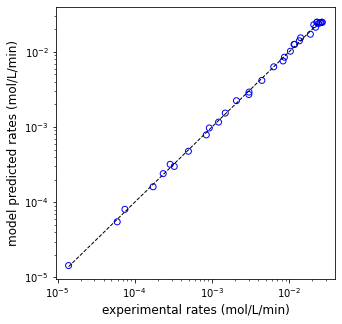

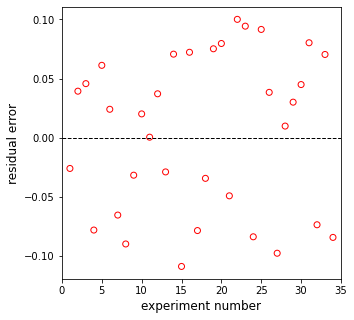

In [18]:
par0 = [100000, 1000, 1000] 
obj4 = lambda par: tempfun4(par, DATA1)[0]
ans4 = opt.minimize(obj4, par0)
print(ans4)

EA, KA, KB = ans4.x
SSE, rmod, rexp, resid = tempfun4([EA, KA, KB], DATA1)

print(f'EA = {EA:5.0f} J/mol, KA = {KA:5.0f} L/mol, KB = {KB:5.0f} L/mol, SSE = {SSE:3.3f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(rexp, rmod, marker = 'o', color = 'none', edgecolor = 'blue')
plt.plot([min(rexp), max(rexp)], [min(rexp), max(rexp)], color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('experimental rates (mol/L/min)', fontsize = 12)
plt.ylabel('model predicted rates (mol/L/min)', fontsize = 12)
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(np.linspace(1, len(rexp), len(rexp)), resid, marker = 'o', color = 'none', edgecolor = 'red')
plt.hlines(0, 0, len(rexp)+1, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlim(0, len(rexp)+1)
plt.xlabel('experiment number', fontsize = 12)
plt.ylabel('residual error', fontsize = 12)
plt.show()

## Example Problem 03

Now let's see if we can do this for the whole data set, where temperatures are actually changing.  We know that equilibrium constants change with temperature, so we cannot use a single, fixed value for KA and KB anymore.  Instead, we have to use a model to describe how they change with temperature.  Here, I'll use a van't Hoff equation, where their values are referenced to the equilibrium constant calculated at the mean reaction temperature.

$$K_i = K_{im}e^{\frac{-\Delta H_i}{RT}\left(\frac{1}{T}-\frac{1}{T_m}\right)}$$

In [19]:
#Load Experimental Times; convert to 1D numpy array
file = open("DATA2.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
DATA2 = np.array(rows, dtype = 'float')
DATA2

array([[1.00e-04, 1.00e-02, 5.73e+02, 2.34e-04],
       [2.00e-04, 1.00e-02, 5.73e+02, 4.96e-04],
       [5.00e-04, 1.00e-02, 5.73e+02, 1.22e-03],
       [1.00e-03, 1.00e-02, 5.73e+02, 2.08e-03],
       [2.00e-03, 1.00e-02, 5.73e+02, 4.44e-03],
       [5.00e-03, 1.00e-02, 5.73e+02, 8.70e-03],
       [1.00e-02, 1.00e-02, 5.73e+02, 1.18e-02],
       [2.00e-02, 1.00e-02, 5.73e+02, 1.41e-02],
       [5.00e-02, 1.00e-02, 5.73e+02, 1.36e-02],
       [1.00e-01, 1.00e-02, 5.73e+02, 1.04e-02],
       [2.00e-01, 1.00e-02, 5.73e+02, 6.33e-03],
       [5.00e-01, 1.00e-02, 5.73e+02, 3.03e-03],
       [1.00e+00, 1.00e-02, 5.73e+02, 1.49e-03],
       [2.00e+00, 1.00e-02, 5.73e+02, 8.46e-04],
       [5.00e+00, 1.00e-02, 5.73e+02, 2.88e-04],
       [1.00e+01, 1.00e-02, 5.73e+02, 1.73e-04],
       [2.00e+01, 1.00e-02, 5.73e+02, 7.46e-05],
       [1.00e-02, 1.00e-04, 5.73e+02, 1.39e-05],
       [1.00e-02, 2.00e-04, 5.73e+02, 5.93e-05],
       [1.00e-02, 5.00e-04, 5.73e+02, 3.25e-04],
       [1.00e-02, 1.

In [20]:
def tempfun5(par, EXPDATA):

    EA, KA0, DHA, KB0, DHB  = par
    
    CA   = EXPDATA[:,0]
    CB   = EXPDATA[:,1]
    T    = EXPDATA[:,2]
    rexp = EXPDATA[:,3]
    
    A   = 1e18 #L^22/mol^2/min
    R   = 8.314
    Tm  = np.mean(T)
    
    k     = A*np.exp(-EA/R/T)
    KA    = KA0*np.exp(-DHA/R*(1/T - 1/Tm))
    KB    = KB0*np.exp(-DHB/R*(1/T - 1/Tm))
    rmod  = k*CA*CB**2/(1 + KA*CA + KB*CB)**2
    resid = (rmod - rexp)/rexp
    SSE   = sum(resid**2);
    return [SSE, rmod, rexp, resid]

# par0 = [100000, 1000, -100000, 1000, -100000]
# tempfun2(par0, DATA2)

EA = 96301 J/mol, KA0 =   710 L/mol, DHA = -109925 J/mol, KB0 =  2128 L/mol, DHB = -102805 J/mol, SSE = 0.549


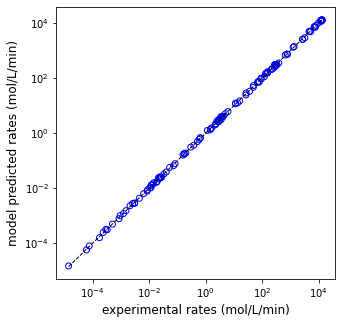

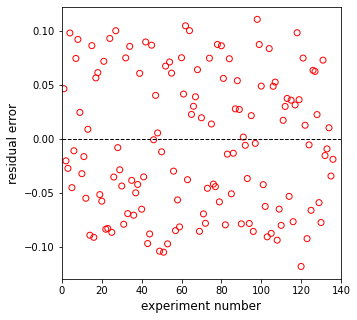

In [21]:
par0 = [100000, 1000, -100000, 1000, -100000]
obj5 = lambda par: tempfun5(par, DATA2)[0]
ans5 = opt.minimize(obj5, par0)
EA, KA0, DHA, KB0, DHB = ans5.x
SSE, rmod, rexp, resid = tempfun5([EA, KA0, DHA, KB0, DHB], DATA2)

print(f'EA = {EA:5.0f} J/mol, KA0 = {KA0:5.0f} L/mol, DHA = {DHA:5.0f} J/mol, KB0 = {KB0:5.0f} L/mol, DHB = {DHB:5.0f} J/mol, SSE = {SSE:5.3f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(rexp, rmod, marker = 'o', color = 'none', edgecolor = 'blue')
plt.plot([min(rexp), max(rexp)], [min(rexp), max(rexp)], color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('experimental rates (mol/L/min)', fontsize = 12)
plt.ylabel('model predicted rates (mol/L/min)', fontsize = 12)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(np.linspace(1, len(rexp), len(rexp)), resid, marker = 'o', color = 'none', edgecolor = 'red')
plt.hlines(0, 0, 140, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlim(0, 140)
plt.xlabel('experiment number', fontsize = 12)
plt.ylabel('residual error', fontsize = 12)
plt.show()